# CSC172 Association Rule Mining Project
## Website User Navigation Pattern Analysis: MSNBC.com Clickstream Data

**Student:** Ian Gabriel Paulmino, 2022-1729  
**Dataset:** MSNBC.com Anonymous Web Data (UCI Repository)


## Project Overview

Each sequence in the dataset corresponds to page views of a user during that twenty-four hour period. Each event in the sequence corresponds to a user's request for a page.

This notebook implements a complete association rule mining pipeline using the Apriori algorithm to discover navigation patterns in website clickstream data. The analysis pipeline includes:

1. **Initial Data Visualization** - Understand raw data characteristics
2. **Data Processing & Cleaning** - Remove incomplete/invalid sessions
3. **Exploratory Data Analysis (EDA)** - Item frequency, transaction sizes, co-occurrence patterns
4. **One-Hot Encoding** - Prepare data for Apriori algorithm
5. **Apriori Implementation** - Generate frequent itemsets and association rules
6. **Evaluation & Visualization** - Metrics analysis and result interpretation

## 1. SETUP & IMPORTS

Import all required libraries for data processing, analysis, and visualization.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Apriori & Association Rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(" All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. CATEGORY MAPPING

Define the mapping from numeric codes (1-17) to content category names.

In [3]:
# Official category mapping from MSNBC dataset
page_categories = {
    1: 'frontpage',
    2: 'news',
    3: 'tech',
    4: 'local',
    5: 'opinion',
    6: 'on-air',
    7: 'misc',
    8: 'weather',
    9: 'health',
    10: 'living',
    11: 'business',
    12: 'sports',
    13: 'summary',
    14: 'bbs',
    15: 'travel',
    16: 'msn-news',
    17: 'msn-sports'
}

print(f"Total categories: {len(page_categories)}")
print("\nCategory Mapping:")
for code, name in page_categories.items():
    print(f"  {code:2d} → {name}")

Total categories: 17

Category Mapping:
   1 → frontpage
   2 → news
   3 → tech
   4 → local
   5 → opinion
   6 → on-air
   7 → misc
   8 → weather
   9 → health
  10 → living
  11 → business
  12 → sports
  13 → summary
  14 → bbs
  15 → travel
  16 → msn-news
  17 → msn-sports


## 3. LOAD RAW DATA

Load the uncompressed MSNBC clickstream data.

In [ ]:
# Load the decompressed .seq file
file_path = 'msnbc990928.seq' 

raw_sequences = []
header_lines = 0

try:
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            
            # Skip header comments
            if line.startswith('%') or line == '':
                header_lines += 1
                continue
            
            # Parse numeric sequences
            try:
                page_codes = [int(x) for x in line.split()]
                raw_sequences.append(page_codes)
            except ValueError:
                continue
    
    print(f" Data loaded successfully!")
    print(f"  • Total raw sessions: {len(raw_sequences):,}")
    print(f"  • Header lines skipped: {header_lines}")
    
except FileNotFoundError:
    print(f"ERROR: File '{file_path}' not found!")
    print("Please make sure the decompressed .seq file is in your working directory.")

✓ Data loaded successfully!
  • Total raw sessions: 989,818
  • Header lines skipped: 6


## 4. INITIAL DATA VISUALIZATION (RAW DATA)

### 4.1 Raw Session Statistics

In [5]:
# Calculate raw statistics
raw_session_lengths = [len(seq) for seq in raw_sequences]

print("="*80)
print("RAW DATA STATISTICS (Before Cleaning)")
print("="*80)

raw_stats = {
    'Total Sessions': len(raw_sequences),
    'Min Pages per Session': min(raw_session_lengths),
    'Max Pages per Session': max(raw_session_lengths),
    'Mean Pages per Session': np.mean(raw_session_lengths),
    'Median Pages per Session': np.median(raw_session_lengths),
    'Std Dev': np.std(raw_session_lengths),
    'Q1 (25th percentile)': np.percentile(raw_session_lengths, 25),
    'Q3 (75th percentile)': np.percentile(raw_session_lengths, 75)
}

for metric, value in raw_stats.items():
    if isinstance(value, int):
        print(f"{metric:.<40} {value:,}")
    else:
        print(f"{metric:.<40} {value:.2f}")

# Session length distribution
print("\nSession Length Distribution (Raw):")
length_counts = Counter(raw_session_lengths)
for length in sorted(length_counts.keys())[:20]:
    count = length_counts[length]
    pct = (count / len(raw_sequences)) * 100
    print(f"  {length:4d} pages: {count:6,} sessions ({pct:5.2f}%)")

RAW DATA STATISTICS (Before Cleaning)
Total Sessions.......................... 989,818
Min Pages per Session................... 1
Max Pages per Session................... 14,795
Mean Pages per Session.................. 4.75
Median Pages per Session................ 2.00
Std Dev................................. 21.26
Q1 (25th percentile).................... 1.00
Q3 (75th percentile).................... 5.00

Session Length Distribution (Raw):
     1 pages: 365,435 sessions (36.92%)
     2 pages: 153,614 sessions (15.52%)
     3 pages: 97,540 sessions ( 9.85%)
     4 pages: 70,090 sessions ( 7.08%)
     5 pages: 56,280 sessions ( 5.69%)
     6 pages: 44,062 sessions ( 4.45%)
     7 pages: 33,961 sessions ( 3.43%)
     8 pages: 27,139 sessions ( 2.74%)
     9 pages: 21,659 sessions ( 2.19%)
    10 pages: 17,662 sessions ( 1.78%)
    11 pages: 14,181 sessions ( 1.43%)
    12 pages: 11,923 sessions ( 1.20%)
    13 pages:  9,963 sessions ( 1.01%)
    14 pages:  8,498 sessions ( 0.86%)
    15 

### 4.2 Raw Category Frequency (Before Cleaning)

RAW CATEGORY FREQUENCIES (Before Cleaning)


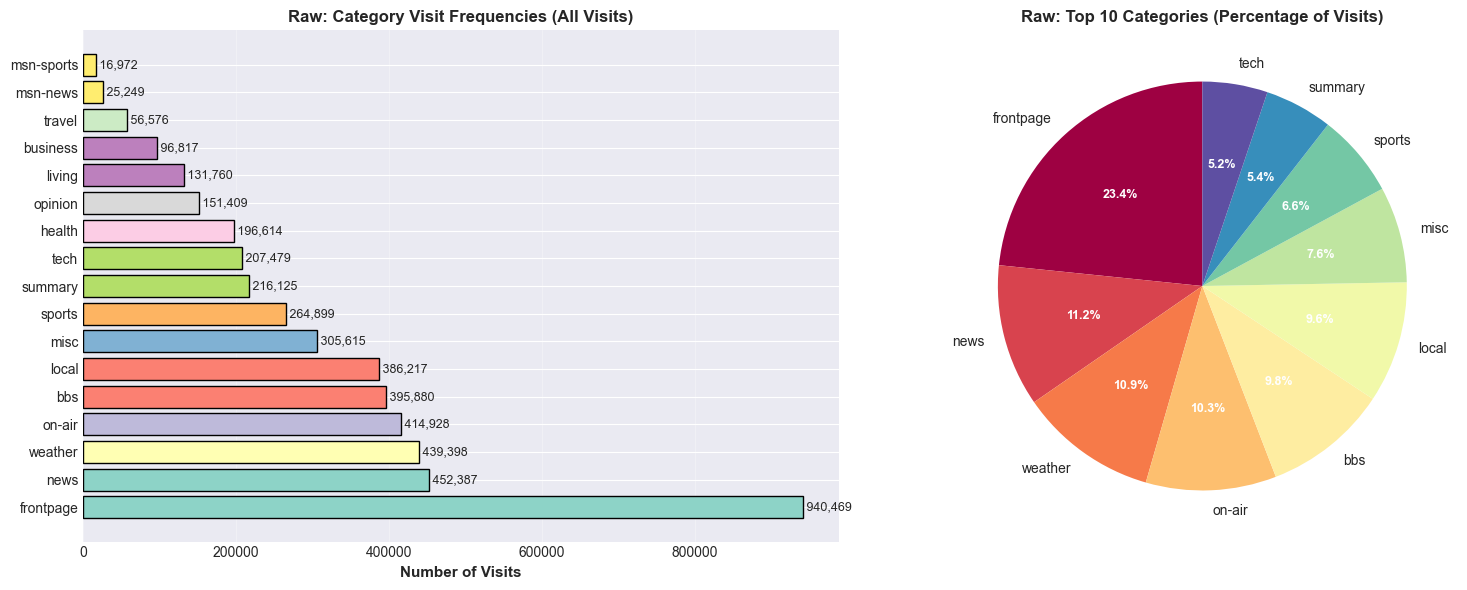

✓ Category frequency visualization saved as '02_raw_category_frequency.png'


In [ ]:
# Count category frequencies in raw data
all_categories_raw = []
for seq in raw_sequences:
    all_categories_raw.extend(seq)

category_counts_raw = Counter(all_categories_raw)

# Map to names
category_freq_raw = {page_categories.get(code, f'unknown_{code}'): count 
                      for code, count in category_counts_raw.items()}
category_freq_raw = dict(sorted(category_freq_raw.items(), key=lambda x: x[1], reverse=True))


print("RAW CATEGORY FREQUENCIES (Before Cleaning)")


total_page_visits = sum(category_freq_raw.values())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart of category frequencies
ax1 = axes[0]
categories = list(category_freq_raw.keys())
frequencies = list(category_freq_raw.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

bars = ax1.barh(categories, frequencies, color=colors, edgecolor='black')
ax1.set_xlabel('Number of Visits', fontsize=11, fontweight='bold')
ax1.set_title('Raw: Category Visit Frequencies (All Visits)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, freq) in enumerate(zip(bars, frequencies)):
    ax1.text(freq, bar.get_y() + bar.get_height()/2, f' {freq:,}', 
            va='center', ha='left', fontsize=9)

# Plot 2: Pie chart of top 10 categories
ax2 = axes[1]
top_10_cats = dict(list(category_freq_raw.items())[:10])
top_10_freqs = list(top_10_cats.values())
top_10_names = list(top_10_cats.keys())

wedges, texts, autotexts = ax2.pie(top_10_freqs, labels=top_10_names, autopct='%1.1f%%',
                                     colors=plt.cm.Spectral(np.linspace(0, 1, 10)),
                                     startangle=90)
ax2.set_title('Raw: Top 10 Categories (Percentage of Visits)', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.tight_layout()
plt.savefig('02_raw_category_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Category frequency visualization saved as '02_raw_category_frequency.png'")



## 5. DATA PROCESSING & CLEANING

### 5.1 Data Cleaning Strategy

**Cleaning Steps:**
1. Convert numeric codes to category names
2. Remove consecutive duplicates (page refreshes within same session)
3. **Filter sessions with <2 distinct categories** (incomplete sessions)
4. Remove sessions with only 'frontpage' visits (no actual content viewing)
5. Final validation and statistics

In [ ]:
print("\n" + "="*80)
print("DATA CLEANING PROCESS")
print("="*80)

# 1: Convert to category names and deduplicate
transactions = []
sessions_removed = {
    'invalid_codes': 0,
    'single_page': 0,
    'frontpage_only': 0,
    'outlier_sessions': 0 
}

for seq_id, seq in enumerate(raw_sequences):
    # Convert codes to names
    page_names = []
    for code in seq:
        if code in page_categories:
            page_names.append(page_categories[code])
        else:
            sessions_removed['invalid_codes'] += 1
            break
    
    if len(page_names) == 0:
        continue
    
    # Remove consecutive duplicates (page refreshes)
    unique_pages = []
    for page in page_names:
        if not unique_pages or unique_pages[-1] != page:
            unique_pages.append(page)
    
    # FILTER 1: Sessions with <2 distinct categories
    if len(unique_pages) < 2:
        sessions_removed['single_page'] += 1
        continue
    
    # FILTER 2: Sessions with only 'frontpage'
    if all(page == 'frontpage' for page in unique_pages):
        sessions_removed['frontpage_only'] += 1
        continue
    
    # Valid session - add to transactions
    transactions.append(unique_pages)

print(f"\nInitial Processing Summary:")
print(f"  • Raw sessions: {len(raw_sequences):,}")
print(f"  • Sessions with invalid codes: {sessions_removed['invalid_codes']:,}")
print(f"  • Sessions with <2 distinct pages: {sessions_removed['single_page']:,}")
print(f"  • Sessions with frontpage only: {sessions_removed['frontpage_only']:,}")
print(f"  • Valid transactions (before outlier filtering): {len(transactions):,}")


# 2: IQR OUTLIER FILTERING (Remove bots/crawlers)
print("\n" + "="*80)
print("IQR OUTLIER FILTERING (Removing Bots/Crawlers)")
print("="*80)

# Calculate session lengths
session_lengths_before = [len(t) for t in transactions]

# Calculate IQR
Q1 = np.percentile(session_lengths_before, 25)
Q3 = np.percentile(session_lengths_before, 75)
IQR = Q3 - Q1

# Define outlier bounds (using 1.5 * IQR - standard method)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Statistics:")
print(f"  • Q1 (25th percentile): {Q1:.2f}")
print(f"  • Q3 (75th percentile): {Q3:.2f}")
print(f"  • IQR (Q3 - Q1): {IQR:.2f}")
print(f"  • Lower bound (Q1 - 1.5*IQR): {lower_bound:.2f}")
print(f"  • Upper bound (Q3 + 1.5*IQR): {upper_bound:.2f}")

# Apply IQR filtering
transactions_filtered = []
outlier_sessions = []

for transaction in transactions:
    session_length = len(transaction)
    if lower_bound <= session_length <= upper_bound:
        transactions_filtered.append(transaction)
    else:
        outlier_sessions.append(session_length)
        sessions_removed['outlier_sessions'] += 1

# Update transactions
transactions_before_filter = len(transactions)
transactions = transactions_filtered

print(f"\nOutlier Filtering Results:")
print(f"  • Sessions before outlier filtering: {transactions_before_filter:,}")
print(f"  • Outliers removed: {sessions_removed['outlier_sessions']:,}")
print(f"  • Sessions retained: {len(transactions):,}")
print(f"  • Retention rate: {(len(transactions)/transactions_before_filter)*100:.2f}%")

# Show some outlier examples
if len(outlier_sessions) > 0:
    outlier_sessions_sorted = sorted(outlier_sessions, reverse=True)
    print(f"\nOutlier Examples (removed sessions):")
    print(f"  • Largest outlier: {outlier_sessions_sorted[0]} pages")
    if len(outlier_sessions_sorted) >= 5:
        print(f"  • Top 5 outliers: {outlier_sessions_sorted[:5]}")
    else:
        print(f"  • All outliers: {outlier_sessions_sorted}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FINAL DATA PROCESSING SUMMARY")
print("="*80)

print(f"\nComplete Pipeline:")
print(f"  1. Raw sessions loaded: {len(raw_sequences):,}")
print(f"  2. Removed invalid codes: -{sessions_removed['invalid_codes']:,}")
print(f"  3. Removed single-page sessions: -{sessions_removed['single_page']:,}")
print(f"  4. Removed frontpage-only sessions: -{sessions_removed['frontpage_only']:,}")
print(f"  5. Removed outlier sessions (IQR): -{sessions_removed['outlier_sessions']:,}")
print(f"  ────────────────────────────────────────")
print(f"  Final valid transactions: {len(transactions):,}")
print(f"\n   Overall retention rate: {(len(transactions)/len(raw_sequences))*100:.2f}%")



DATA CLEANING PROCESS

Initial Processing Summary:
  • Raw sessions: 989,818
  • Sessions with invalid codes: 0
  • Sessions with <2 distinct pages: 601,384
  • Sessions with frontpage only: 0
  • Valid transactions (before outlier filtering): 388,434

IQR OUTLIER FILTERING (Removing Bots/Crawlers)

IQR Statistics:
  • Q1 (25th percentile): 2.00
  • Q3 (75th percentile): 5.00
  • IQR (Q3 - Q1): 3.00
  • Lower bound (Q1 - 1.5*IQR): -2.50
  • Upper bound (Q3 + 1.5*IQR): 9.50

Outlier Filtering Results:
  • Sessions before outlier filtering: 388,434
  • Outliers removed: 24,050
  • Sessions retained: 364,384
  • Retention rate: 93.81%

Outlier Examples (removed sessions):
  • Largest outlier: 1810 pages
  • Top 5 outliers: [1810, 1433, 1206, 1179, 569]

FINAL DATA PROCESSING SUMMARY

Complete Pipeline:
  1. Raw sessions loaded: 989,818
  2. Removed invalid codes: -0
  3. Removed single-page sessions: -601,384
  4. Removed frontpage-only sessions: -0
  5. Removed outlier sessions (IQR): -

### 5.2 Cleaned Data Statistics

In [13]:
# Calculate cleaned statistics
cleaned_lengths = [len(t) for t in transactions]

print("\n" + "="*80)
print("CLEANED DATA STATISTICS (After Filtering)")
print("="*80)

cleaned_stats = {
    'Total Valid Sessions': len(transactions),
    'Min Pages per Session': min(cleaned_lengths),
    'Max Pages per Session': max(cleaned_lengths),
    'Mean Pages per Session': np.mean(cleaned_lengths),
    'Median Pages per Session': np.median(cleaned_lengths),
    'Std Dev': np.std(cleaned_lengths),
    'Q1 (25th percentile)': np.percentile(cleaned_lengths, 25),
    'Q3 (75th percentile)': np.percentile(cleaned_lengths, 75)
}

for metric, value in cleaned_stats.items():
    if isinstance(value, int):
        print(f"{metric:.<40} {value:,}")
    else:
        print(f"{metric:.<40} {value:.2f}")

# Comparison
print(f"\n" + "="*80)
print("BEFORE vs AFTER CLEANING COMPARISON")
print("="*80)
print(f"\nMetric{'':<36} Raw Data{'':<15} Cleaned Data{'':<10} Change")
print("-"*80)
print(f"Total Sessions{'':<30} {len(raw_sequences):>15,} {len(transactions):>20,} {((len(transactions)/len(raw_sequences))*100):>8.1f}%")
print(f"Mean Length{'':<33} {np.mean(raw_session_lengths):>15.2f} {np.mean(cleaned_lengths):>20.2f} {((np.mean(cleaned_lengths)/np.mean(raw_session_lengths))*100):>8.1f}%")
print(f"Median Length{'':<31} {np.median(raw_session_lengths):>15.0f} {np.median(cleaned_lengths):>20.0f}")
print(f"Max Length{'':<34} {max(raw_session_lengths):>15,} {max(cleaned_lengths):>20,}")


CLEANED DATA STATISTICS (After Filtering)
Total Valid Sessions.................... 364,384
Min Pages per Session................... 2
Max Pages per Session................... 9
Mean Pages per Session.................. 3.55
Median Pages per Session................ 3.00
Std Dev................................. 1.80
Q1 (25th percentile).................... 2.00
Q3 (75th percentile).................... 4.00

BEFORE vs AFTER CLEANING COMPARISON

Metric                                     Raw Data                Cleaned Data           Change
--------------------------------------------------------------------------------
Total Sessions                                       989,818              364,384     36.8%
Mean Length                                             4.75                 3.55     74.9%
Median Length                                              2                    3
Max Length                                            14,795                    9


### 5.3 Compare Before and After Cleaning - Visualization

C:\Users\Acer Nitro\AppData\Local\Temp\ipykernel_26644\910766931.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([raw_session_lengths], labels=['Raw Data'], patch_artist=True, vert=True, widths=0.6)
C:\Users\Acer Nitro\AppData\Local\Temp\ipykernel_26644\910766931.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot([cleaned_lengths], labels=['Cleaned Data'], patch_artist=True, vert=True, widths=0.6)


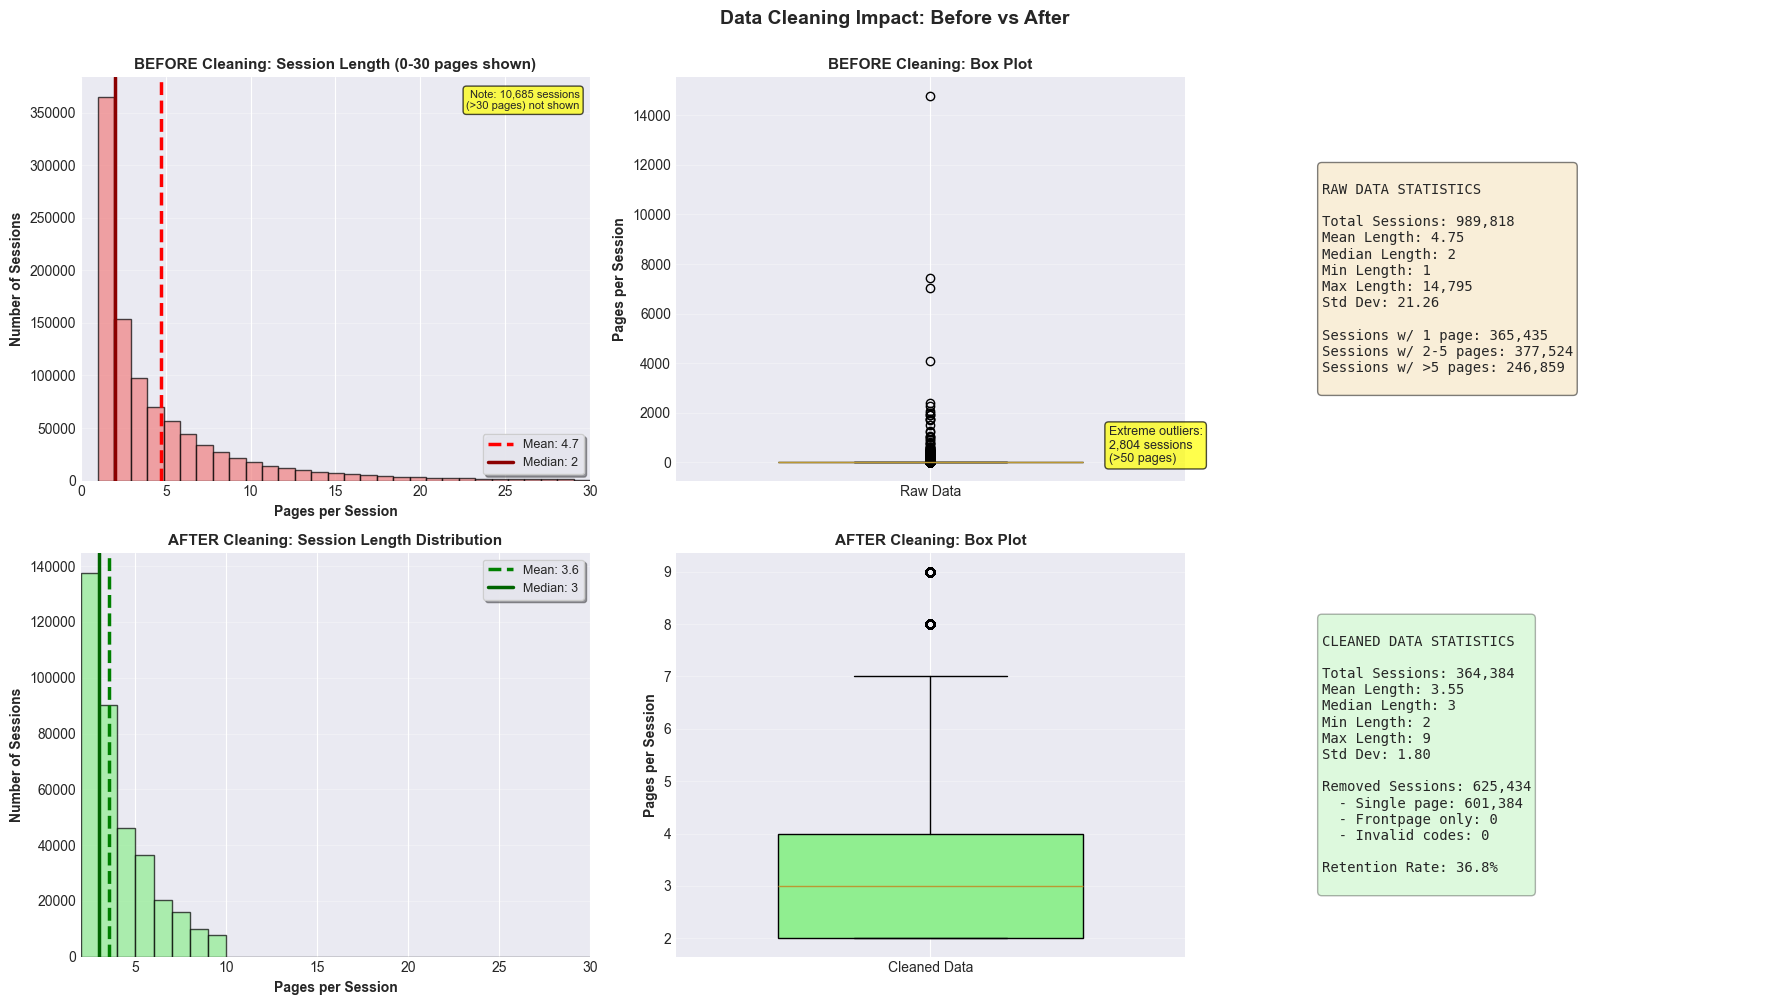

✓ Before/After comparison visualization saved as '03_before_after_cleaning.png'


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- ROW 1: RAW DATA ---
# Raw Histogram (FILTERED VIEW for readability)
ax1 = axes[0, 0]
raw_filtered = [x for x in raw_session_lengths if x <= 30]  # Filter to 0-30 for visibility
ax1.hist(raw_filtered, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(raw_session_lengths), color='red', linestyle='--', linewidth=2.5, 
            label=f'Mean: {np.mean(raw_session_lengths):.1f}')
ax1.axvline(np.median(raw_session_lengths), color='darkred', linestyle='-', linewidth=2.5, 
            label=f'Median: {np.median(raw_session_lengths):.0f}')
ax1.set_xlabel('Pages per Session', fontsize=10, fontweight='bold')
ax1.set_ylabel('Number of Sessions', fontsize=10, fontweight='bold')
ax1.set_title('BEFORE Cleaning: Session Length (0-30 pages shown)', fontsize=11, fontweight='bold')
ax1.legend(fontsize=9, frameon=True, fancybox=True, shadow=True, framealpha=0.95)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim(0, 30)

# Add note about extreme outliers
ax1.text(0.98, 0.97, f'Note: {sum(1 for x in raw_session_lengths if x > 30):,} sessions\n(>30 pages) not shown', 
         transform=ax1.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Raw Box plot
ax2 = axes[0, 1]
bp = ax2.boxplot([raw_session_lengths], labels=['Raw Data'], patch_artist=True, vert=True, widths=0.6)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax2.set_ylabel('Pages per Session', fontsize=10, fontweight='bold')
ax2.set_title('BEFORE Cleaning: Box Plot', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add key statistics as text
outliers_raw = sum(1 for x in raw_session_lengths if x > 50)
ax2.text(1.35, np.median(raw_session_lengths), 
         f'Extreme outliers:\n{outliers_raw:,} sessions\n(>50 pages)', 
         fontsize=9, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Raw Info Text
ax3 = axes[0, 2]
ax3.axis('off')
info_text = f"""
RAW DATA STATISTICS

Total Sessions: {len(raw_sequences):,}
Mean Length: {np.mean(raw_session_lengths):.2f}
Median Length: {np.median(raw_session_lengths):.0f}
Min Length: {min(raw_session_lengths)}
Max Length: {max(raw_session_lengths):,}
Std Dev: {np.std(raw_session_lengths):.2f}

Sessions w/ 1 page: {sum(1 for x in raw_session_lengths if x == 1):,}
Sessions w/ 2-5 pages: {sum(1 for x in raw_session_lengths if 2 <= x <= 5):,}
Sessions w/ >5 pages: {sum(1 for x in raw_session_lengths if x > 5):,}
"""
ax3.text(0.1, 0.5, info_text, fontsize=10, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# --- ROW 2: CLEANED DATA ---
# Cleaned Histogram
ax4 = axes[1, 0]
ax4.hist(cleaned_lengths, bins=range(2, 31), color='lightgreen', edgecolor='black', alpha=0.7)
ax4.axvline(np.mean(cleaned_lengths), color='green', linestyle='--', linewidth=2.5, 
            label=f'Mean: {np.mean(cleaned_lengths):.1f}')
ax4.axvline(np.median(cleaned_lengths), color='darkgreen', linestyle='-', linewidth=2.5, 
            label=f'Median: {np.median(cleaned_lengths):.0f}')
ax4.set_xlabel('Pages per Session', fontsize=10, fontweight='bold')
ax4.set_ylabel('Number of Sessions', fontsize=10, fontweight='bold')
ax4.set_title('AFTER Cleaning: Session Length Distribution', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9, frameon=True, fancybox=True, shadow=True, framealpha=0.95)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_xlim(2, 30)

# Cleaned Box plot
ax5 = axes[1, 1]
bp = ax5.boxplot([cleaned_lengths], labels=['Cleaned Data'], patch_artist=True, vert=True, widths=0.6)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
ax5.set_ylabel('Pages per Session', fontsize=10, fontweight='bold')
ax5.set_title('AFTER Cleaning: Box Plot', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Cleaned Info Text
ax6 = axes[1, 2]
ax6.axis('off')
info_text_clean = f"""
CLEANED DATA STATISTICS

Total Sessions: {len(transactions):,}
Mean Length: {np.mean(cleaned_lengths):.2f}
Median Length: {np.median(cleaned_lengths):.0f}
Min Length: {min(cleaned_lengths)}
Max Length: {max(cleaned_lengths):,}
Std Dev: {np.std(cleaned_lengths):.2f}

Removed Sessions: {len(raw_sequences) - len(transactions):,}
  - Single page: {sessions_removed['single_page']:,}
  - Frontpage only: {sessions_removed['frontpage_only']:,}
  - Invalid codes: {sessions_removed['invalid_codes']:,}

Retention Rate: {(len(transactions)/len(raw_sequences))*100:.1f}%
"""
ax6.text(0.1, 0.5, info_text_clean, fontsize=10, verticalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))

plt.suptitle('Data Cleaning Impact: Before vs After', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('03_before_after_cleaning.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Before/After comparison visualization saved as '03_before_after_cleaning.png'")


### 5.4 Sample Cleaned Transactions

In [32]:
print("\n" + "="*80)
print("SAMPLE CLEANED TRANSACTIONS")
print("="*80)

print(f"\nDisplaying first 15 valid transactions:\n")

for i, transaction in enumerate(transactions[:15], 1):
    pages = ' → '.join(transaction)
    print(f"Transaction {i:2d} ({len(transaction)} pages): {pages}")

print(f"\n... (and {len(transactions) - 15:,} more transactions)")


SAMPLE CLEANED TRANSACTIONS

Displaying first 15 valid transactions:

Transaction  1 (5 pages): tech → news → local → news → tech
Transaction  2 (4 pages): on-air → misc → on-air → weather
Transaction  3 (9 pages): on-air → health → local → living → tech → living → opinion → living → local
Transaction  4 (3 pages): frontpage → business → frontpage
Transaction  5 (2 pages): health → sports
Transaction  6 (2 pages): on-air → health
Transaction  7 (2 pages): news → on-air
Transaction  8 (4 pages): on-air → misc → on-air → misc
Transaction  9 (3 pages): news → local → tech
Transaction 10 (4 pages): weather → frontpage → misc → weather
Transaction 11 (4 pages): summary → weather → summary → bbs
Transaction 12 (2 pages): frontpage → weather
Transaction 13 (2 pages): summary → bbs
Transaction 14 (2 pages): summary → health
Transaction 15 (3 pages): frontpage → tech → frontpage

... (and 364,369 more transactions)


---

## 6. EXPLORATORY DATA ANALYSIS (EDA)

### 6.1 Item Frequency Analysis

In [16]:
print("\n" + "="*80)
print("CLEANED DATA: CATEGORY FREQUENCIES & SESSION APPEARANCES")
print("="*80)

# Count how many sessions each category appears in
category_session_counts = Counter()
for transaction in transactions:
    unique_cats = set(transaction)
    for cat in unique_cats:
        category_session_counts[cat] += 1

# Sort by frequency
sorted_categories = sorted(category_session_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nRank | Category{'':<10} | Sessions | % of Sessions | Support")
print("-"*80)

for rank, (cat, count) in enumerate(sorted_categories, 1):
    pct = (count / len(transactions)) * 100
    support = count / len(transactions)  # Support metric
    print(f"{rank:2d}   | {cat:15s} | {count:8,} | {pct:12.2f}% | {support:.4f}")

print(f"\nTotal unique categories appearing: {len(sorted_categories)}")


CLEANED DATA: CATEGORY FREQUENCIES & SESSION APPEARANCES

Rank | Category           | Sessions | % of Sessions | Support
--------------------------------------------------------------------------------
 1   | frontpage       |  183,982 |        50.49% | 0.5049
 2   | news            |  102,662 |        28.17% | 0.2817
 3   | on-air          |   96,287 |        26.42% | 0.2642
 4   | local           |   75,866 |        20.82% | 0.2082
 5   | misc            |   67,892 |        18.63% | 0.1863
 6   | bbs             |   67,278 |        18.46% | 0.1846
 7   | sports          |   62,704 |        17.21% | 0.1721
 8   | tech            |   60,732 |        16.67% | 0.1667
 9   | health          |   53,605 |        14.71% | 0.1471
10   | business        |   39,469 |        10.83% | 0.1083
11   | weather         |   35,704 |         9.80% | 0.0980
12   | summary         |   35,602 |         9.77% | 0.0977
13   | living          |   33,858 |         9.29% | 0.0929
14   | travel          |   20,

### 6.2 Item Frequency Visualizations

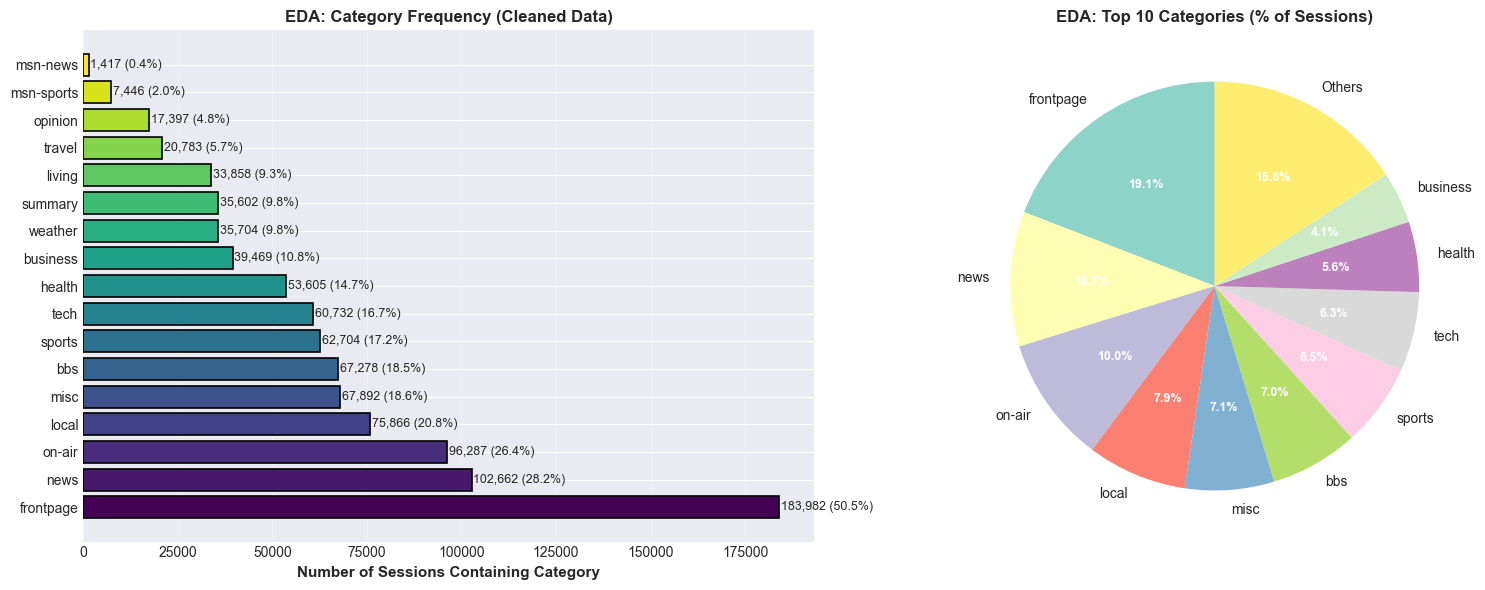

✓ Item frequency visualization saved as '04_eda_item_frequency.png'


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract data for plotting
categories_sorted = [cat for cat, _ in sorted_categories]
frequencies_sorted = [count for _, count in sorted_categories]
percentages_sorted = [(count/len(transactions))*100 for _, count in sorted_categories]

# Plot 1: Horizontal bar chart
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(categories_sorted)))
bars = ax1.barh(categories_sorted, frequencies_sorted, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Number of Sessions Containing Category', fontsize=11, fontweight='bold')
ax1.set_title('EDA: Category Frequency (Cleaned Data)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add labels
for i, (bar, freq, pct) in enumerate(zip(bars, frequencies_sorted, percentages_sorted)):
    ax1.text(freq + 500, bar.get_y() + bar.get_height()/2, 
            f'{freq:,} ({pct:.1f}%)', va='center', ha='left', fontsize=9)

# Plot 2: Pie chart of top 10
ax2 = axes[1]
top_10_cats_sorted = sorted_categories[:10]
top_10_names = [cat for cat, _ in top_10_cats_sorted]
top_10_freqs = [count for _, count in top_10_cats_sorted]
other_freq = sum(freq for _, freq in sorted_categories[10:])

pie_data = top_10_freqs + [other_freq]
pie_labels = top_10_names + ['Others']
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(pie_data)))

wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90)
ax2.set_title('EDA: Top 10 Categories (% of Sessions)', fontsize=12, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

plt.tight_layout()
plt.savefig('04_eda_item_frequency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Item frequency visualization saved as '04_eda_item_frequency.png'")

### 6.3 Transaction Size Analysis

In [18]:
print("\n" + "="*80)
print("EDA: TRANSACTION SIZE ANALYSIS")
print("="*80)

# Analyze transaction sizes
transaction_sizes = Counter(cleaned_lengths)

print(f"\n{'':<20} Transaction Size Distribution:")
print("-"*80)
print(f"Size | Count{'':<10} | % of Total | Cumulative %")
print("-"*80)

cumulative = 0
for size in sorted(transaction_sizes.keys()):
    count = transaction_sizes[size]
    pct = (count / len(transactions)) * 100
    cumulative += pct
    if size <= 10 or size % 5 == 0:  # Show first 10 and every 5th after
        print(f"{size:2d}   | {count:8,} | {pct:9.2f}% | {cumulative:8.2f}%")

# Summary statistics
print("\n" + "-"*80)
print(f"Statistics:")
print(f"  • 1-2 items:     {sum(count for size, count in transaction_sizes.items() if size <= 2):8,} sessions ({(sum(count for size, count in transaction_sizes.items() if size <= 2)/len(transactions))*100:6.2f}%)")
print(f"  • 3-5 items:     {sum(count for size, count in transaction_sizes.items() if 3 <= size <= 5):8,} sessions ({(sum(count for size, count in transaction_sizes.items() if 3 <= size <= 5)/len(transactions))*100:6.2f}%)")
print(f"  • 6-10 items:    {sum(count for size, count in transaction_sizes.items() if 6 <= size <= 10):8,} sessions ({(sum(count for size, count in transaction_sizes.items() if 6 <= size <= 10)/len(transactions))*100:6.2f}%)")
print(f"  • >10 items:     {sum(count for size, count in transaction_sizes.items() if size > 10):8,} sessions ({(sum(count for size, count in transaction_sizes.items() if size > 10)/len(transactions))*100:6.2f}%)")


EDA: TRANSACTION SIZE ANALYSIS

                     Transaction Size Distribution:
--------------------------------------------------------------------------------
Size | Count           | % of Total | Cumulative %
--------------------------------------------------------------------------------
 2   |  137,733 |     37.80% |    37.80%
 3   |   90,236 |     24.76% |    62.56%
 4   |   45,938 |     12.61% |    75.17%
 5   |   36,499 |     10.02% |    85.19%
 6   |   20,389 |      5.60% |    90.78%
 7   |   15,901 |      4.36% |    95.15%
 8   |    9,871 |      2.71% |    97.85%
 9   |    7,817 |      2.15% |   100.00%

--------------------------------------------------------------------------------
Statistics:
  • 1-2 items:      137,733 sessions ( 37.80%)
  • 3-5 items:      172,673 sessions ( 47.39%)
  • 6-10 items:      53,978 sessions ( 14.81%)
  • >10 items:            0 sessions (  0.00%)


### 6.5 Co-occurrence Heatmap (Top 15 Categories)


EDA: CO-OCCURRENCE ANALYSIS

Co-occurrence matrix created for top 15 categories
Analyzing which categories appear together in sessions...

Top 15 Category Pairs (Co-occurrences):

 1. frontpage    + news         : 60,789 sessions ( 16.68%)
 2. frontpage    + sports       : 35,051 sessions (  9.62%)
 3. frontpage    + bbs          : 32,023 sessions (  8.79%)
 4. frontpage    + on-air       : 31,707 sessions (  8.70%)
 5. frontpage    + local        : 29,669 sessions (  8.14%)
 6. frontpage    + misc         : 27,432 sessions (  7.53%)
 7. frontpage    + tech         : 26,726 sessions (  7.33%)
 8. on-air       + misc         : 26,655 sessions (  7.32%)
 9. frontpage    + business     : 25,346 sessions (  6.96%)
10. frontpage    + living       : 19,812 sessions (  5.44%)
11. local        + misc         : 19,398 sessions (  5.32%)
12. news         + tech         : 19,051 sessions (  5.23%)
13. news         + local        : 18,919 sessions (  5.19%)
14. news         + on-air       : 17,72

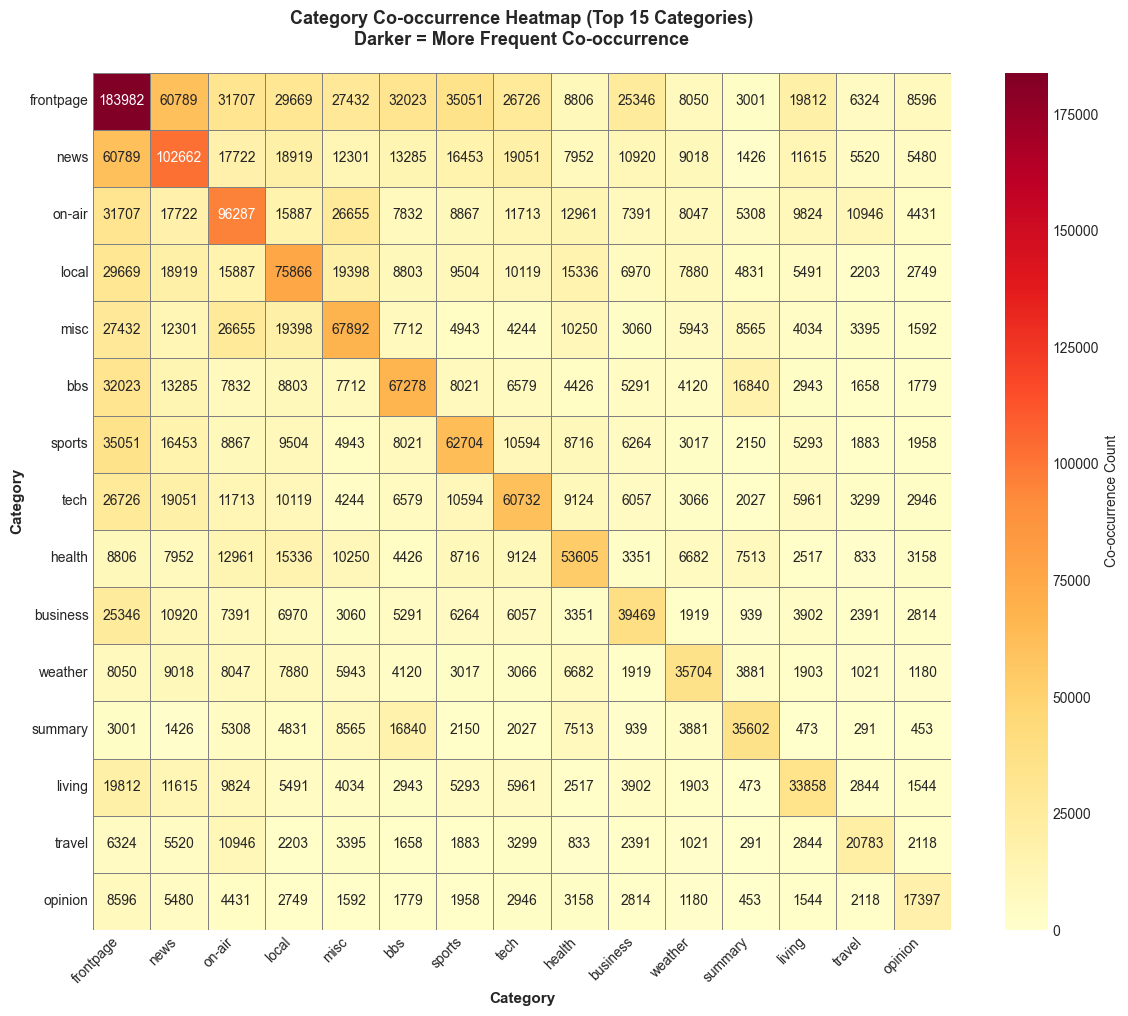


✓ Co-occurrence heatmap saved as '06_eda_cooccurrence_heatmap.png'


In [20]:
print("\n" + "="*80)
print("EDA: CO-OCCURRENCE ANALYSIS")
print("="*80)

# Get top 15 categories
top_15_categories = [cat for cat, _ in sorted_categories[:15]]

# Create co-occurrence matrix
cooccurrence = pd.DataFrame(0, index=top_15_categories, columns=top_15_categories)

for transaction in transactions:
    # Get unique categories in this transaction
    unique_in_transaction = list(set([cat for cat in transaction if cat in top_15_categories]))
    
    # Mark co-occurrences
    for i, cat1 in enumerate(unique_in_transaction):
        for cat2 in unique_in_transaction:
            cooccurrence.loc[cat1, cat2] += 1

print(f"\nCo-occurrence matrix created for top 15 categories")
print(f"Analyzing which categories appear together in sessions...\n")

# Show top co-occurrences
print("Top 15 Category Pairs (Co-occurrences):\n")
cooccurrence_pairs = []
for i, cat1 in enumerate(top_15_categories):
    for j, cat2 in enumerate(top_15_categories):
        if i < j:  # Avoid duplicates and self-pairs
            count = cooccurrence.loc[cat1, cat2]
            if count > 0:
                pct = (count / len(transactions)) * 100
                cooccurrence_pairs.append((cat1, cat2, count, pct))

cooccurrence_pairs.sort(key=lambda x: x[2], reverse=True)

for rank, (cat1, cat2, count, pct) in enumerate(cooccurrence_pairs[:15], 1):
    print(f"{rank:2d}. {cat1:12s} + {cat2:12s} : {count:6,} sessions ({pct:6.2f}%)")

# ============================================================================
# CO-OCCURRENCE HEATMAP VISUALIZATION
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap with better color scheme
sns.heatmap(cooccurrence, 
            annot=True,           # Show numbers
            fmt='d',              # Integer format
            cmap='YlOrRd',        # Yellow-Orange-Red color scheme
            cbar_kws={'label': 'Co-occurrence Count'},
            ax=ax,
            linewidths=0.5,       # Grid lines
            linecolor='gray',     # Grid color
            square=True,          # Square cells
            vmin=0)               # Start from 0

# Styling
ax.set_title('Category Co-occurrence Heatmap (Top 15 Categories)\nDarker = More Frequent Co-occurrence', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_xlabel('Category', fontsize=11, fontweight='bold')
ax.set_ylabel('Category', fontsize=11, fontweight='bold')

# Rotate labels for readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('06_eda_cooccurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Co-occurrence heatmap saved as '06_eda_cooccurrence_heatmap.png'")




## 7. ONE-HOT ENCODING & DATA PREPARATION FOR APRIORI

### 7.1 Encode Transactions Using TransactionEncoder

In [ ]:
print("ONE-HOT ENCODING FOR APRIORI")

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\n✓ One-hot encoding completed!")
print(f"\n  • Input: {len(transactions):,} transactions")
print(f"  • Categories (features): {df_encoded.shape[1]}")
print(f"  • Output matrix shape: {df_encoded.shape}")
print(f"  • Data type: Boolean (True/False)")



ONE-HOT ENCODING FOR APRIORI

✓ One-hot encoding completed!

  • Input: 364,384 transactions
  • Categories (features): 17
  • Output matrix shape: (364384, 17)
  • Data type: Boolean (True/False)


---

## 8. APRIORI ALGORITHM IMPLEMENTATION

### 8.1 Generate Frequent Itemsets

In [24]:
print("\n" + "="*80)
print("APRIORI ALGORITHM: FREQUENT ITEMSETS GENERATION")
print("="*80)

# Parameters
min_support = 0.05

print(f"\nAlgorithm Parameters:")
print(f"  • min_support: {min_support} ({min_support*100}% of transactions)")
print(f"  • Threshold: itemset must appear in ≥{int(min_support*len(transactions))} transactions")

# Run Apriori
print(f"\nRunning Apriori algorithm...")
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

print(f"\n Apriori completed!")
print(f"\n Frequent itemsets found: {len(frequent_itemsets)}")



APRIORI ALGORITHM: FREQUENT ITEMSETS GENERATION

Algorithm Parameters:
  • min_support: 0.05 (5.0% of transactions)
  • Threshold: itemset must appear in ≥18219 transactions

Running Apriori algorithm...

 Apriori completed!

 Frequent itemsets found: 27


In [25]:
# Sort by support
frequent_itemsets_sorted = frequent_itemsets.sort_values('support', ascending=False)

print("\n" + "="*80)
print("TOP 20 FREQUENT ITEMSETS")
print("="*80)

print(f"\nRank | Itemset{'':<40} | Support | % of Trans. | Count")
print("-"*80)

for rank, (idx, row) in enumerate(frequent_itemsets_sorted.head(20).iterrows(), 1):
    itemset = ', '.join(sorted(list(row['itemsets'])))
    support = row['support']
    pct = support * 100
    count = int(support * len(transactions))
    print(f"{rank:2d}   | {itemset:43s} | {support:.4f} | {pct:10.2f}% | {count:6,}")


TOP 20 FREQUENT ITEMSETS

Rank | Itemset                                         | Support | % of Trans. | Count
--------------------------------------------------------------------------------
 1   | frontpage                                   | 0.5049 |      50.49% | 183,982
 2   | news                                        | 0.2817 |      28.17% | 102,662
 3   | on-air                                      | 0.2642 |      26.42% | 96,287
 4   | local                                       | 0.2082 |      20.82% | 75,866
 5   | misc                                        | 0.1863 |      18.63% | 67,892
 6   | bbs                                         | 0.1846 |      18.46% | 67,278
 7   | sports                                      | 0.1721 |      17.21% | 62,704
 8   | frontpage, news                             | 0.1668 |      16.68% | 60,789
 9   | tech                                        | 0.1667 |      16.67% | 60,732
10   | health                                      | 0.1

---

## 9. ASSOCIATION RULES GENERATION

### 9.1 Generate Association Rules

In [26]:
print("GENERATING ASSOCIATION RULES")


# Generate rules
min_confidence = 0.20
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

print(f"\n✓ Generated {len(rules)} association rules (min_confidence={min_confidence})")

# Calculate additional metrics
rules['antecedent_support'] = rules['antecedents'].apply(
    lambda x: frequent_itemsets[frequent_itemsets['itemsets'] == x]['support'].values[0]
)
rules['consequent_support'] = rules['consequents'].apply(
    lambda x: frequent_itemsets[frequent_itemsets['itemsets'] == x]['support'].values[0]
)
rules['leverage'] = rules['support'] - (rules['antecedent_support'] * rules['consequent_support'])
rules['conviction'] = (1 - rules['consequent_support']) / (1 - rules['confidence'])
rules['conviction'] = rules['conviction'].replace([np.inf, -np.inf], np.nan)

print("✓ Calculated: Lift, Leverage, Conviction")

# ============================================================================
# TOP RULES SUMMARY
# ============================================================================

print("\n" + "="*80)
print("TOP 10 ASSOCIATION RULES (Sorted by Lift)")
print("="*80)

rules_sorted = rules.sort_values('lift', ascending=False)

print(f"\nRank | Rule{'':<35} | Support | Confidence | Lift")
print("-"*80)

for rank, (idx, row) in enumerate(rules_sorted.head(10).iterrows(), 1):
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    rule = f"{ant} → {cons}"
    print(f"{rank:2d}   | {rule:38s} | {row['support']:.3f}   | {row['confidence']:.3f}      | {row['lift']:.3f}")

# ============================================================================
# METRICS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("METRICS SUMMARY")
print("="*80)

print(f"""
Support    - Mean: {rules['support'].mean():.3f}  | Range: [{rules['support'].min():.3f}, {rules['support'].max():.3f}]
Confidence - Mean: {rules['confidence'].mean():.3f}  | Range: [{rules['confidence'].min():.3f}, {rules['confidence'].max():.3f}]
Lift       - Mean: {rules['lift'].mean():.3f}  | Range: [{rules['lift'].min():.3f}, {rules['lift'].max():.3f}]

Rule Strength Distribution:
  • Strong (Lift ≥ 1.3):     {len(rules[rules['lift'] >= 1.3])} rules
  • Moderate (Lift 1.2-1.3): {len(rules[(rules['lift'] >= 1.2) & (rules['lift'] < 1.3)])} rules
  • Weak (Lift < 1.2):       {len(rules[rules['lift'] < 1.2])} rules
""")

print("="*80)
print(" Association Rules Analysis Complete!")
print("="*80)


GENERATING ASSOCIATION RULES

✓ Generated 16 association rules (min_confidence=0.2)
✓ Calculated: Lift, Leverage, Conviction

TOP 10 ASSOCIATION RULES (Sorted by Lift)

Rank | Rule                                    | Support | Confidence | Lift
--------------------------------------------------------------------------------
 1   | misc → on-air                          | 0.073   | 0.393      | 1.486
 2   | on-air → misc                          | 0.073   | 0.277      | 1.486
 3   | misc → local                           | 0.053   | 0.286      | 1.372
 4   | local → misc                           | 0.053   | 0.256      | 1.372
 5   | business → frontpage                   | 0.070   | 0.642      | 1.272
 6   | news → frontpage                       | 0.167   | 0.592      | 1.173
 7   | frontpage → news                       | 0.167   | 0.330      | 1.173
 8   | living → frontpage                     | 0.054   | 0.585      | 1.159
 9   | tech → news                            | 0.052   |

### 9.2 Visualization: Support vs Confidence

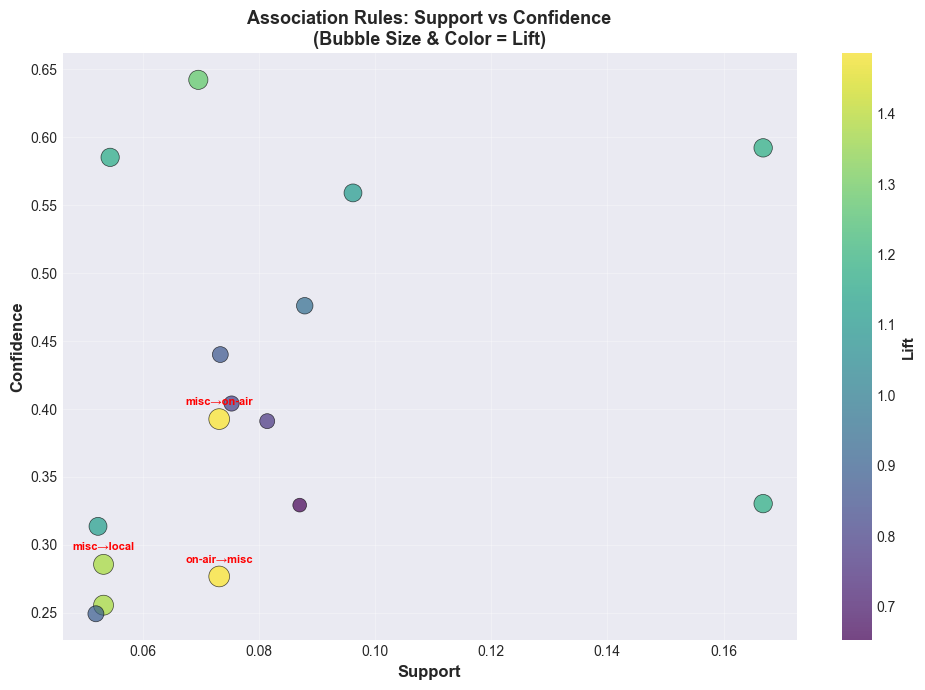


 Visualization saved as 'association_rules_visualization.png'


In [27]:
plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    rules['support'],
    rules['confidence'],
    c=rules['lift'],
    s=rules['lift'] * 150,
    cmap='viridis',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

plt.xlabel('Support', fontsize=12, fontweight='bold')
plt.ylabel('Confidence', fontsize=12, fontweight='bold')
plt.title('Association Rules: Support vs Confidence\n(Bubble Size & Color = Lift)', 
          fontsize=13, fontweight='bold')

cbar = plt.colorbar(scatter)
cbar.set_label('Lift', fontsize=11, fontweight='bold')

# Annotate top 3 rules
top_3 = rules_sorted.head(3)
for idx, row in top_3.iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    label = f"{ant}→{cons}"
    plt.annotate(label, 
                 (row['support'], row['confidence']),
                 textcoords="offset points", 
                 xytext=(0, 10),
                 ha='center', 
                 fontsize=8, 
                 color='red',
                 fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('association_rules_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'association_rules_visualization.png'")
